In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from nltk.metrics import ConfusionMatrix
from collections import defaultdict

In [2]:
df = pd.read_csv('table_for_prediction_updated_with_diff_target.csv')

In [3]:
df = df.drop(df.head().index)

In [20]:
df

,Session,Form,Grade,WCPM,Acc,Comp,Exp,level,WCPM_zscore,Acc_zscore,...,gyorP,gyorQ,mlevel_numeric,form_numeric,mlevel_form_diff,text_is_above_level,Acc4,AvgSpan,AccOverSpanNonSW,DiffTarget
5,13956,Grade1Fall,Grade1,39.0,0.925,4.6,2.5,6,-0.683468,0.308893,...,3,0.0,6,4,2,1,0.732094,0.421267,0.250000,Hard
6,13961,Grade1Fall,Grade1,42.0,0.926,6.4,2.9,6,-0.601303,0.317423,...,3,3.0,6,4,2,1,0.735265,0.802896,0.760000,Right
7,16375,Grade1Fall,Grade1,36.0,0.916,6.9,1.3,5,-0.765632,0.232121,...,3,2.0,5,4,1,1,0.704015,0.484642,1.000000,Right
8,16412,Grade3Fall,Grade3,51.0,0.841,2.3,1.9,9,-1.137568,-1.090938,...,1,2.0,9,12,-3,0,0.500246,0.651935,0.651515,Hard
9,16585,Grade3Fall,Grade3,44.0,0.798,1.8,1.8,8,-1.362436,-1.610184,...,3,3.0,8,12,-4,0,0.405519,0.621095,0.847222,Hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,53803,Grade4Spring,Grade4,122.0,1.000,4.4,3.7,16,0.404977,0.676739,...,3,3.0,16,17,-1,0,1.000000,1.000000,0.967213,Right
1199,53945,Grade1Winter,Grade1,64.0,1.000,7.0,2.2,9,0.007175,0.877031,...,3,3.0,9,6,3,1,1.000000,1.000000,0.909091,Right
1200,54096,Grade4Winter,Grade4,124.0,0.997,5.7,3.6,17,1.127903,0.572681,...,3,3.0,17,16,1,1,0.988054,1.000000,0.921875,Right
1201,54166,Grade4Spring,Grade4,124.0,0.996,6.5,3.6,16,0.461105,0.624682,...,3,3.0,16,17,-1,0,0.984096,1.000000,0.950820,Right


In [80]:
def get_max(lst):
    return sorted(lst)[int(len(lst) * .98)] # get rid of outliers, hacky

def get_combination_string(combination, metrics):
    output = ['{:.2f} * {}'.format(c, m)  for c, m in zip(combination, metrics)]
    return ' + '.join(output)

def bins_counts_overlap(bins_counts):
    gyor_val_combinations = itertools.combinations(bins_counts.keys(), 2)
    comb_to_jaccard = {}
    for comb in gyor_val_combinations:
        bins_A = bins_counts[comb[0]]
        bins_B = bins_counts[comb[1]]
        min_idx = min(min(bins_A), min(bins_B))
        max_idx = max(max(bins_A), max(bins_B))
        all_overlap = 0
        all_unique = 0
        for i in range(min_idx, max_idx + 1):
            A_count = bins_A.count(i)
            B_count = bins_B.count(i)
            overlap = min(A_count, B_count)
            unique = max(A_count, B_count) - overlap
            all_overlap += overlap
            all_unique += unique
        comb_to_jaccard[comb] = all_overlap / (all_overlap + all_unique)
    return comb_to_jaccard

In [81]:
df['AccOverSpanNonSW'] = df.AccOverSpanNonSW.apply(lambda x: x ** 2)

In [82]:
def plot_linear_combinations(grade, metrics=['WCPM', 'Acc4'], grain=4):
    ct = 1
    df_grade = df.loc[df.Form == grade].fillna(0)
    df_grade = df_grade.copy(deep=True)
    for metric in metrics:
        df_grade[metric + '_scaled'] = np.interp(
            df_grade[metric], 
            (df_grade[metric].min(), get_max(df_grade[metric])), 
            (0, 1))
    intervals = list(np.linspace(0, 1, grain))
    df_values_submatrix = np.array(df_grade[[metric + '_scaled' for metric in metrics]])
    interval_combinations = itertools.product(*[intervals for _ in range(len(metrics))])
    comb_to_average_jaccard = {}
    
    best_combination = None
    lowest_jaccard = 1
    for combination in interval_combinations:
        if sum(combination) == 0:
            continue
        combination_vector = np.array(combination).reshape((len(combination), 1))
        df_grade['lin_comb'] = df_values_submatrix @ combination_vector
#         plt.figure(figsize=(5, 3))
        
        lin_comb_min, lin_comb_max = min(df_grade.lin_comb), max(df_grade.lin_comb)
        bin_step = .2
        bins = [lin_comb_min - 0.001 + i * bin_step for i in range(0, int((lin_comb_max - lin_comb_min) / bin_step) + 2)]
        bins_counts = {}
        
        for gyor_val, gyor_color in zip(
                ['Right', 'Easy', 'Hard'], 
                ['lightgreen', 'gold', 'firebrick']):
            df_grade_selected = df_grade.loc[df_grade.DiffTarget == gyor_val]
            binned_lin_comb = np.digitize(df_grade_selected.lin_comb, bins, right=True)
            bins_counts[gyor_val] = sorted(binned_lin_comb)
#             sns.distplot(df_grade_selected.lin_comb, color=gyor_color, hist_kws=dict(alpha=.2))\
#                 .set_title(grade + '\n' + get_combination_string(combination, metrics))
        jaccards = bins_counts_overlap(bins_counts)
        avg_jaccard = np.mean([y for x, y in jaccards.items()])
        comb_to_average_jaccard[get_combination_string(combination, metrics)] = avg_jaccard
        if avg_jaccard < lowest_jaccard:
            lowest_jaccard = avg_jaccard
            best_combination = combination
            
    combination_vector = np.array(best_combination).reshape((len(best_combination), 1))
    df_grade['lin_comb'] = df_values_submatrix @ combination_vector
    plt.figure(figsize=(8, 5))

    lin_comb_min, lin_comb_max = min(df_grade.lin_comb), max(df_grade.lin_comb)
    bin_step = .2
    bins = [lin_comb_min - 0.001 + i * bin_step for i in range(0, int((lin_comb_max - lin_comb_min) / bin_step) + 2)]
    bins_counts = {}
    max_lin_comb_val = -1
    for gyor_val, gyor_color in zip(
            ['Right', 'Easy', 'Hard'], 
            ['lightgreen', 'gold', 'firebrick']):
        df_grade_selected = df_grade.loc[df_grade.DiffTarget == gyor_val]
        
        binned_lin_comb = np.digitize(df_grade_selected.lin_comb, bins, right=True)
        bins_counts[gyor_val] = sorted(binned_lin_comb)
        max_lin_comb_val = max(max_lin_comb_val, max(df_grade_selected.lin_comb))
        sns.distplot(
            df_grade_selected.lin_comb,
            color=gyor_color,
            hist_kws=dict(alpha=.2)).set_title(grade + '\n' + get_combination_string(best_combination, metrics))
    plt.xticks(np.arange(0, int(max_lin_comb_val) + 1, .25))
#     plt.savefig('new_' + grade + '.png')
    plt.show()
#     jaccards = bins_counts_overlap(bins_counts)
#     avg_jaccard = np.mean([y for x, y in jaccards.items()])
#     comb_to_average_jaccard[get_combination_string(combination, metrics)] = avg_jaccard
    return sorted([(comb, comb_val) for comb, comb_val in comb_to_average_jaccard.items()], key=lambda xy: xy[1])[0],\
        df_grade[['Session', 'DiffTarget', 'lin_comb']], best_combination, get_combination_string(best_combination, metrics)

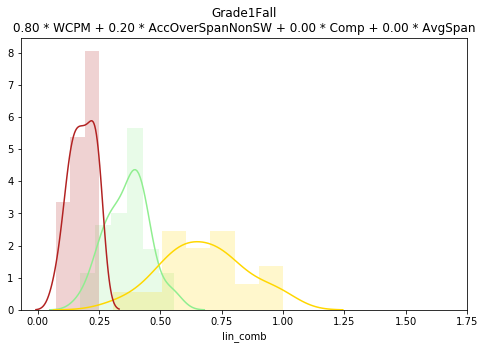

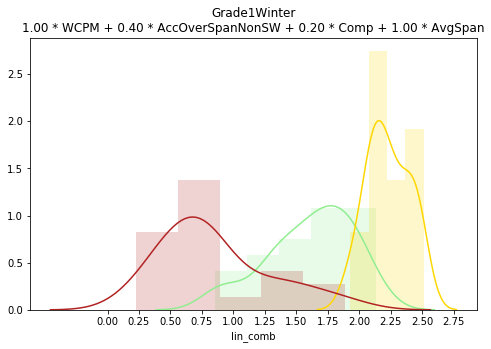

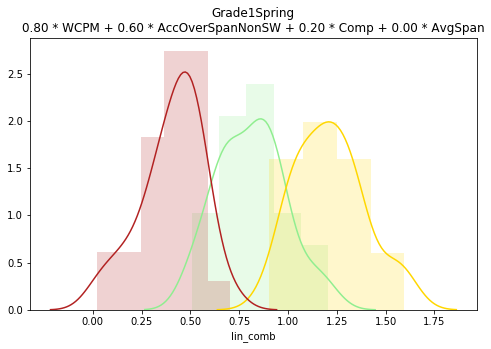

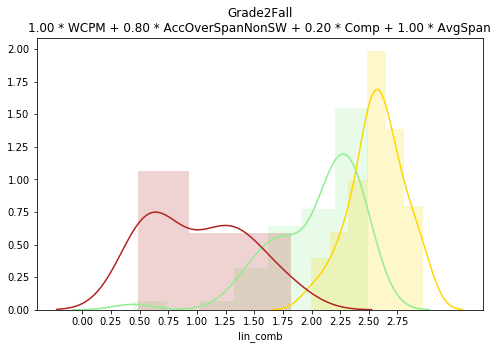

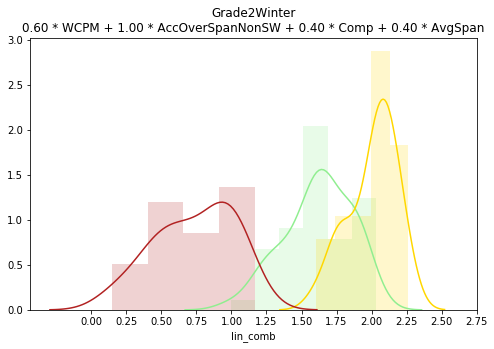

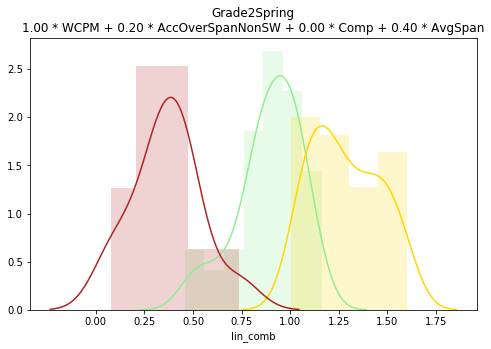

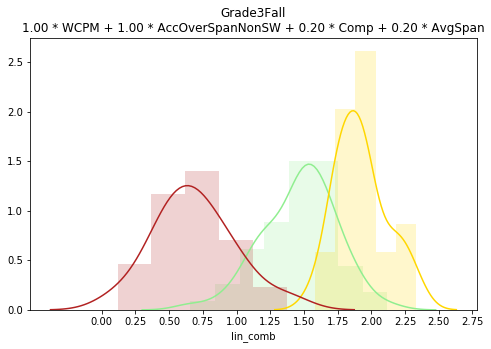

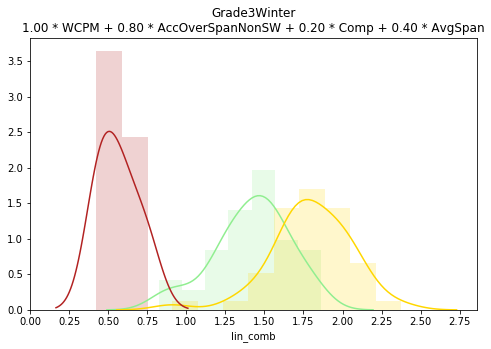

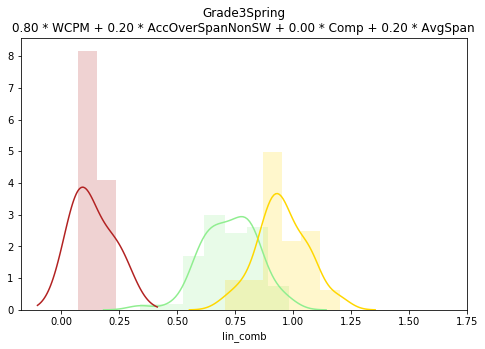

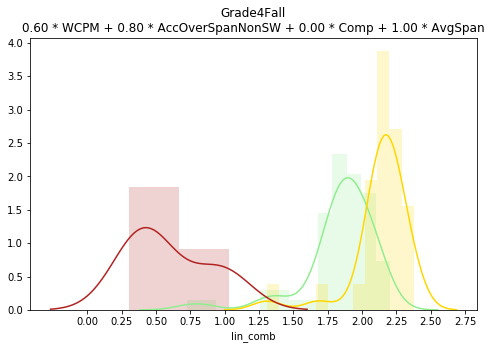

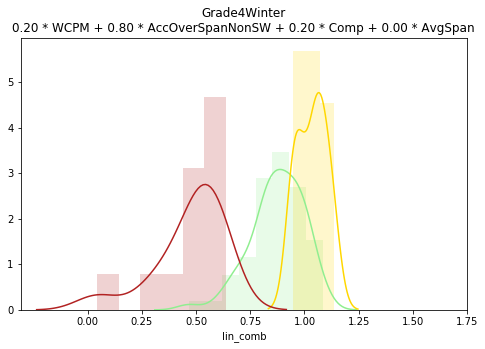

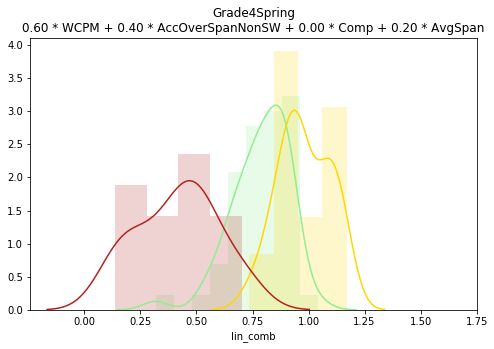

In [83]:
form_to_best_combination_table = {}
form_to_best_combination = {}
for grade in ('Grade1', 'Grade2', 'Grade3', 'Grade4'):
    for term in ('Fall', 'Winter', 'Spring'):
        comb_to_average_jaccard, partial_df, combination, comb_str = plot_linear_combinations(
            grade + term,
            metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
            grain=6)
        form_to_best_combination_table[grade + term] = partial_df
        form_to_best_combination[grade + term] = comb_str

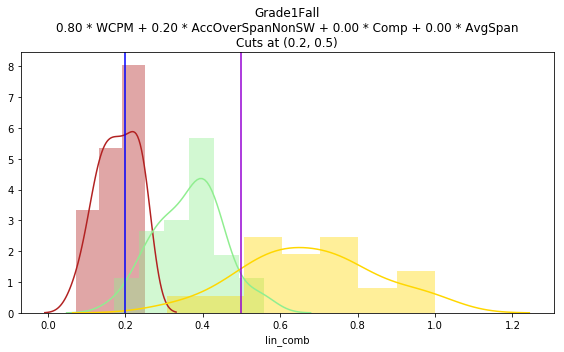

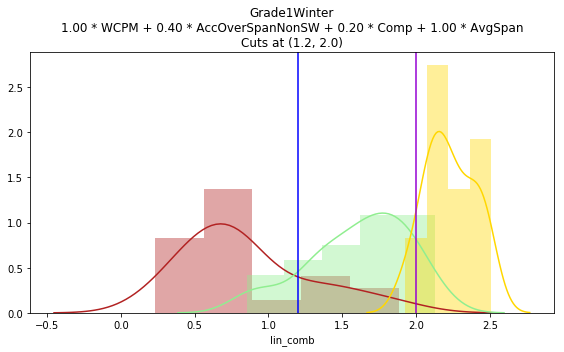

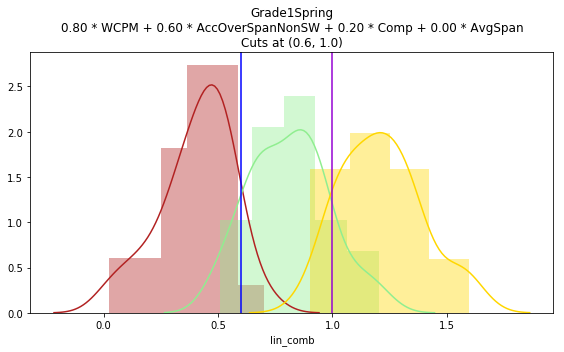

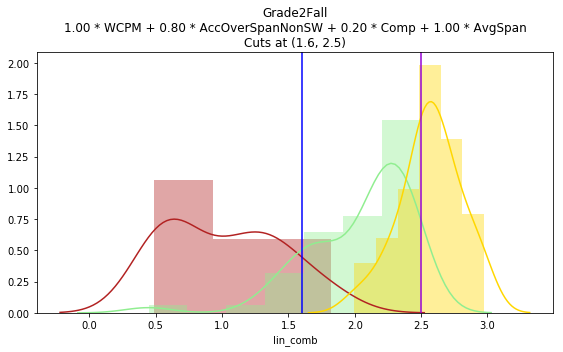

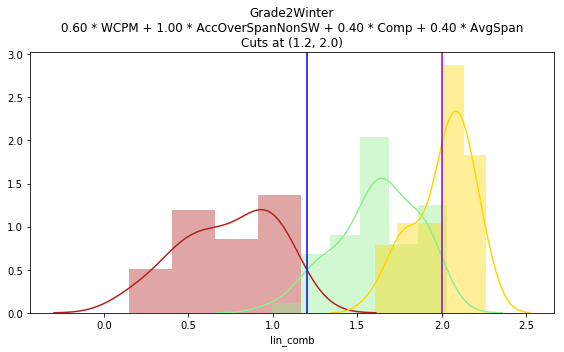

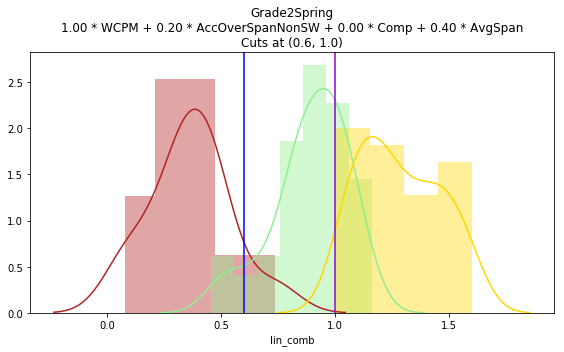

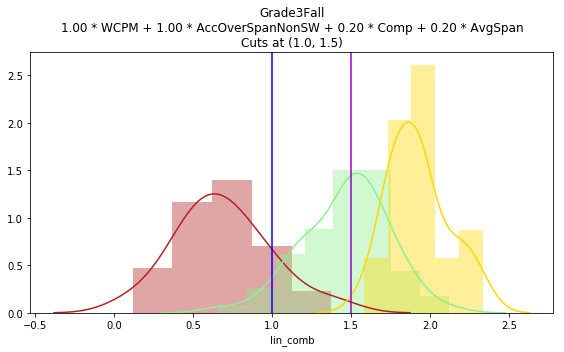

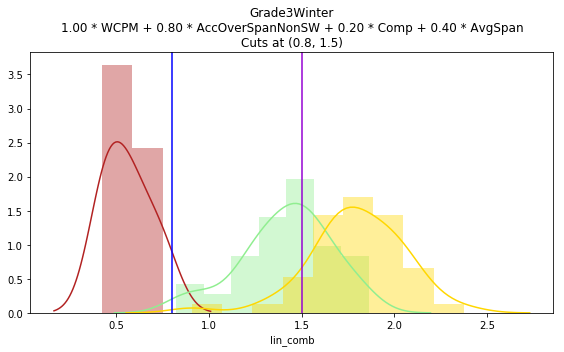

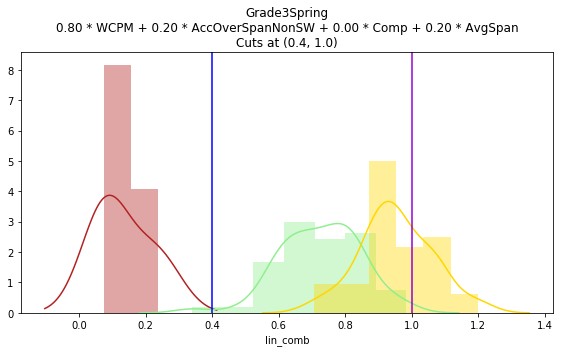

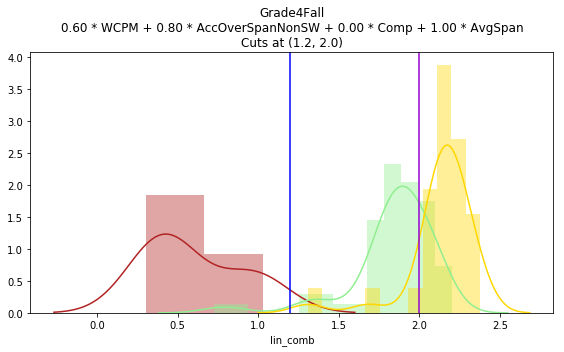

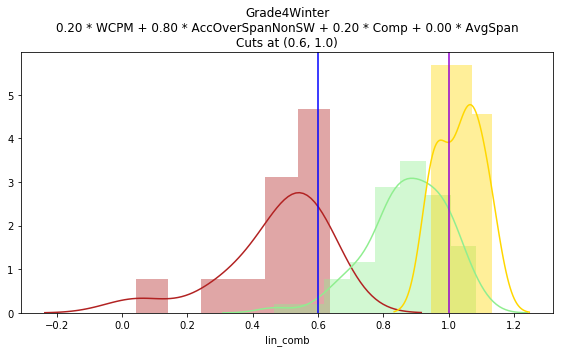

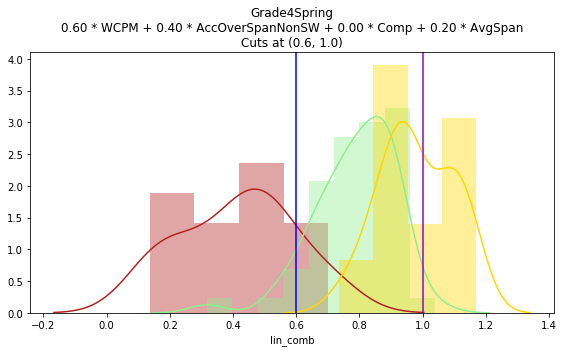

In [95]:
NORMALIZE = True
form_to_cutpoint = {}
session_to_linear_combination = {}
session_to_difftarget = {}
for form, tbl in form_to_best_combination_table.items():
    for _, row in tbl.iterrows():
        session_to_linear_combination[row.Session] = row.lin_comb
        session_to_difftarget[row.Session] = row.DiffTarget
        
    plt.figure(figsize=(8, 5))
    
    for color, difficulty_level in zip(('firebrick', 'lightgreen', 'gold'), ('Hard', 'Right', 'Easy')):
        sns.distplot(tbl.loc[tbl.DiffTarget == difficulty_level].lin_comb, color=color)
        
    smallest_red_green_overlap = 1000
    best_cutpoint = 4
    num_red = len(tbl.loc[tbl.DiffTarget == 'Hard'])
    num_green = len(tbl.loc[tbl.DiffTarget == 'Right'])
    num_yellow = len(tbl.loc[tbl.DiffTarget == 'Easy'])
    for red_green_cutpoint in np.arange(0.2, 3, .2):
        below_cutpoint = tbl.loc[tbl.lin_comb < red_green_cutpoint]
        above_cutpoint = tbl.loc[tbl.lin_comb >= red_green_cutpoint]
        n_green_under = len(below_cutpoint.loc[below_cutpoint.DiffTarget == 'Right'])
        n_red_over = len(above_cutpoint.loc[above_cutpoint.DiffTarget == 'Hard'])
        
        if NORMALIZE:
            n_green_under /= num_green
            n_red_over /= num_red
        
        if n_green_under + n_red_over < smallest_red_green_overlap:
            smallest_red_green_overlap = n_green_under + n_red_over
            best_cutpoint = red_green_cutpoint
    
    plt.axvline(best_cutpoint, 0, 4, color='blue')
    
    smallest_green_yellow_overlap = 1000
    best_cutpoint_2 = 4
    for green_yellow_cutpoint in np.arange(0, 3, .5):
        below_cutpoint = tbl.loc[tbl.lin_comb < green_yellow_cutpoint]
        above_cutpoint = tbl.loc[tbl.lin_comb >= green_yellow_cutpoint]
        n_yellow_under = len(below_cutpoint.loc[below_cutpoint.DiffTarget == 'Easy'])
        n_green_over = len(above_cutpoint.loc[above_cutpoint.DiffTarget == 'Right'])
        if NORMALIZE:
            n_yellow_under /= num_yellow
            n_green_over /= num_green
        if n_yellow_under + n_green_over < smallest_green_yellow_overlap:
            smallest_green_yellow_overlap = n_yellow_under + n_green_over
            best_cutpoint_2 = green_yellow_cutpoint
    plt.axvline(best_cutpoint_2, 0, 4, color='darkviolet')
    plt.title(form + '\n' + form_to_best_combination[form] + '\nCuts at ({:.1f}, {:.1f})'.format(best_cutpoint, best_cutpoint_2))
    plt.tight_layout()
    plt.savefig('optim_cutpoints_' + form + '.png')
    form_to_cutpoint[form] = (best_cutpoint, best_cutpoint_2)

In [96]:
diff_to_num = {
    'Right': 2,
    'Easy': 3,
    'Hard': 1
}
def get_diff_to_num(lst):
    return [diff_to_num[x] for x in lst]

In [98]:
cumulative_conf_mat = np.zeros((3,3))
all_accs = []
for form, (low_cut, high_cut) in form_to_cutpoint.items():
    tbl = form_to_best_combination_table[form].copy(deep=True)
    def assign(x):
        if x < low_cut:
            return 'Hard'
        if low_cut < x <= high_cut:
            return 'Right'
        return 'Easy'
    tbl['PredTarget'] = tbl.lin_comb.apply(assign)
    
    true = get_diff_to_num(tbl.DiffTarget)
    pred = get_diff_to_num(tbl.PredTarget)
    
    cm_str = ConfusionMatrix(true, pred)
    print('Form =', form)
    
    cm = confusion_matrix(true, pred)
    acc = cm.trace() / cm.sum()
    all_accs.append(acc)
    cumulative_conf_mat += cm
    print('acc = {:.2f}%'.format(acc * 100))
    print(cm_str)

print('median accuracy:', np.median(all_accs))
print('all sessions:')
print(cumulative_conf_mat)
print('raw: {} / {} = {:.3f}'.format(cumulative_conf_mat.trace(), cumulative_conf_mat.sum(), cumulative_conf_mat.trace() / cumulative_conf_mat.sum()))

Form = Grade1Fall
acc = 82.52%
  |  1  2  3 |
--+----------+
1 |<15> 9  1 |
2 |  1<37> 3 |
3 |  .  4<33>|
--+----------+
(row = reference; col = test)

Form = Grade1Winter
acc = 82.98%
  |  1  2  3 |
--+----------+
1 |<17> 5  . |
2 |  5<38> 4 |
3 |  .  2<23>|
--+----------+
(row = reference; col = test)

Form = Grade1Spring
acc = 88.00%
  |  1  2  3 |
--+----------+
1 |<28> 1  . |
2 |  4<34> 4 |
3 |  .  3<26>|
--+----------+
(row = reference; col = test)

Form = Grade2Fall
acc = 80.58%
  |  1  2  3 |
--+----------+
1 |<17> 2  . |
2 |  7<46> . |
3 |  . 11<20>|
--+----------+
(row = reference; col = test)

Form = Grade2Winter
acc = 84.47%
  |  1  2  3 |
--+----------+
1 |<23> .  . |
2 |  3<47> 1 |
3 |  . 12<17>|
--+----------+
(row = reference; col = test)

Form = Grade2Spring
acc = 81.44%
  |  1  2  3 |
--+----------+
1 |<11> 1  . |
2 |  4<31>13 |
3 |  .  .<37>|
--+----------+
(row = reference; col = test)

Form = Grade3Fall
acc = 64.71%
  |  1  2  3 |
--+----------+
1 |<14> 3  . |
2 | 